In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

# 1. データの確認

今回のハンズオンでは、とある金融機関における金融商品（定期預金）の電話営業のデータを利用します。

データの出典は以下になります。

Moro,S., Rita,P., and Cortez,P.. (2012). Bank Marketing. UCI Machine Learning Repository. https://doi.org/10.24432/C5K306.

ダウンロードしたフォルダの中にあるbank-additional/bank-additional-full.csvを今回利用します。

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Googleドライブのマイドライブ直下にcsvファイルを保存している場合
df = pd.read_csv("/content/drive/MyDrive/bank-additional-full.csv", sep=";") # 必要に応じてパスは変更してください
df

In [ ]:
df.columns

顧客の属性情報や、社会情勢に関する指数、そして最終的に契約に至ったかどうかの情報が記録されています。

今回はこのデータを元に、将来の電話営業の際に、架電対象を探すためのモデルを作ることにします。  

より具体的には、__お客様ごとに、商品を買ってくれそうかどうかを予測し、買ってくれそうだと判断されたお客様に電話をすること__を想定して、モデルを作ってみます。

今回のデータにおいては"y"列が、実際に商品を買ったかどうかを表す列になるので、これを予測するタスクにします。

In [ ]:
df["y"].value_counts()

過去実績では、40,000人ほどに架電営業をし、そのうちの1割程度が購入してくれていることがわかります。

## データの加工

今回は、ニューラルネットワークを用いた学習モデルを利用します。

ニューラルネットワークへの入力は数値である必要があるため、この表を数値データへ加工します。

また、今回のタスクにおいて、一部リークに近い特徴量があるため、これを事前に削除しておきます。

In [ ]:
# リーク特徴量の削除
df = df.drop("duration", axis=1)

# モデルへの入力と、ターゲットに分離
df_X = df.drop("y", axis=1)
df_y = df["y"]

まず、予測対象の"outcome"ですが、yes/noの二値になっています。

このため、これを1/0で表現します。

In [ ]:
# 2値なので、yes=1、no=0とする
df_y = np.array([1 if i == "yes" else 0 for i in df_y])

次に、入力する情報ですが、文字列が多く含まれているので、これを数値に変換します。

ここでは、One-Hot Encodingと呼ばれる手法を用います。

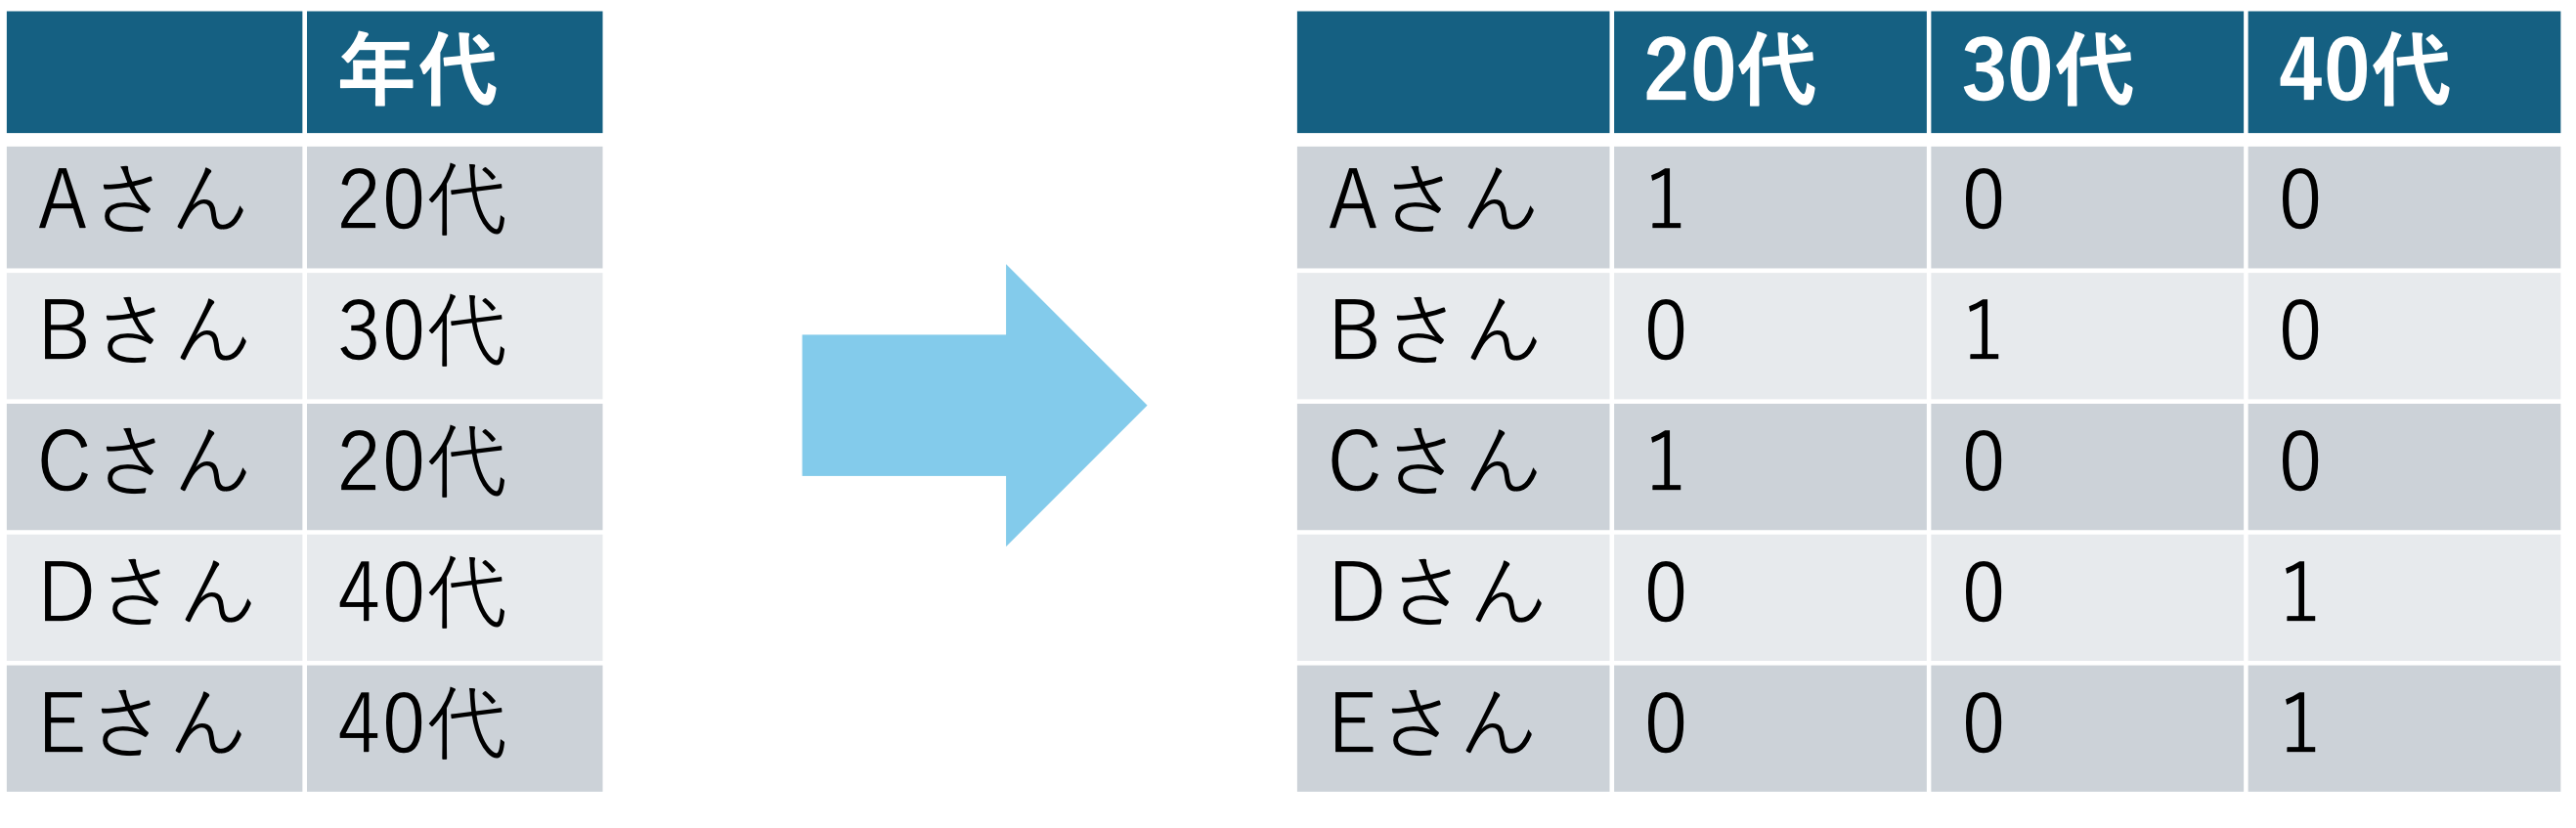

In [ ]:
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]

In [ ]:
df_X_2 = pd.get_dummies(df_X, columns=categorical_features, dtype=float)

また、一般にニューラルネットワークでは、入力する数値をすべて正規化しておいたほうが良いことが多いです。

そのため、すべての数値を0〜1の範囲になるように正規化します。

In [ ]:
numerical_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]

In [ ]:
# (元の値 - 最小値) / (最大値 - 最小値)で正規化
df_X_3 = df_X_2.copy()
df_X_3[numerical_features] = (df_X_2[numerical_features] - df_X_2[numerical_features].min()) / (df_X_2[numerical_features].max() - df_X_2[numerical_features].min())

これにより、入力データを数値化できました。

In [ ]:
df_X_3

## データの分割

最後に、出来上がったデータを学習用データ、検証用データ、評価用データに分割します。

以後は、ここで作成したデータを利用して、モデルの学習を行います。

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(df_X_3, df_y, train_size=0.8, random_state=0)
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, train_size=0.8, random_state=0)

In [ ]:
print(f"training data: {train_X.shape}, {train_y.shape}")
print(f"validation data: {valid_X.shape}, {valid_y.shape}")
print(f"evaluation data: {test_X.shape}, {test_y.shape}")

---

# 2. ニューラルネットワークの学習

用意したデータを用いて、まずはニューラルネットワークの学習を試してみましょう。

In [ ]:
# データの変換（numpy.ndarray -> torch.tensor）
train_X = torch.tensor(train_X.values, dtype=torch.float)
valid_X = torch.tensor(valid_X.values, dtype=torch.float)
test_X = torch.tensor(test_X.values, dtype=torch.float)

train_y = torch.tensor(train_y, dtype=torch.float)
valid_y = torch.tensor(valid_y, dtype=torch.float)
test_y = torch.tensor(test_y, dtype=torch.float)

In [ ]:
# モデルの定義
torch.manual_seed(0)

model = nn.Sequential(
    nn.Linear(62, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [ ]:
# 学習用のパラメータの指定
epochs = 200
batch_size = 128
lr = 1e-4
early_stopping_rounds = 20
optimizer = torch.optim.Adam(model.parameters(), lr)
criterion = nn.BCELoss()

In [ ]:
# torchのデータセット型に変換
train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
def train_model(model: torch.nn.Module, optimizer: torch.optim) -> torch.nn.Module:
    best_valid_loss = 100
    best_epoch = 0
    best_params = None
    early_stopping_count = 0

    train_loss_records = []
    valid_loss_records = []

    for epoch in tqdm(range(1, epochs+1)):
        sum_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y.reshape(-1,1))
            sum_loss += loss
            loss.backward()
            optimizer.step()

        train_loss_records.append(float(sum_loss) / len(train_loader))

        # validation
        with torch.no_grad():
            output = model(valid_X)
            valid_loss = criterion(output, valid_y.reshape(-1,1))

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                best_epoch = epoch
                best_params = model.state_dict()
                early_stopping_count = 0
            else:
                early_stopping_count += 1

            valid_loss_records.append(float(valid_loss))

        # early stopping
        if early_stopping_count >= early_stopping_rounds:
            print(f"early stopping at epoch {best_epoch}")
            print(f"best valid loss: {best_valid_loss:.4f}")
            break

        if epoch % 10 == 0:
            print(f"epoch: {epoch}")
            print(f"valid loss: {valid_loss:.4f}")

    # plot training process
    plt.plot(train_loss_records)
    plt.plot(valid_loss_records)
    plt.legend(["train_loss", "valid_loss"])

    # return best model
    model.load_state_dict(best_params)

    return model

In [ ]:
model = train_model(model, optimizer)

損失関数の値が順調に低下していき、epoch:10ぐらいで十分に学習できている様子が見えます。

それ以降はやや過学習気味の挙動をしています。

early stopping時点でのモデルを使って、評価用データで評価してみます。

In [ ]:
def eval_model(model: torch.nn.Module):

    with torch.no_grad():
        output = model(test_X)
        loss = criterion(output, test_y.reshape(-1, 1))
        print(f"BCELoss:\t{float(loss):.4f}")

        output_label = [1 if i >= 0.5 else 0 for i in output]

        acc = metrics.accuracy_score(test_y, output_label)
        recall = metrics.recall_score(test_y, output_label)
        precision = metrics.precision_score(test_y, output_label)
        print("------")
        print(f"accuracy:\t{acc:.4f}")
        print(f"recall:\t\t{recall:.4f}")
        print(f"precision:\t{precision:.4f}")

        roc_auc = metrics.roc_auc_score(test_y, output.detach().numpy())
        print(f"roc_auc:\t{roc_auc:.4f}")

In [ ]:
eval_model(model)

---

# 3. 行列積演算子への分解

このニューラルネットワークの重み行列の一つを取り出し、これを行列積状態へと変換します。

ここでは、2層目の$256 \times 256$の行列を取り出して、4つの行列の積に分解します。

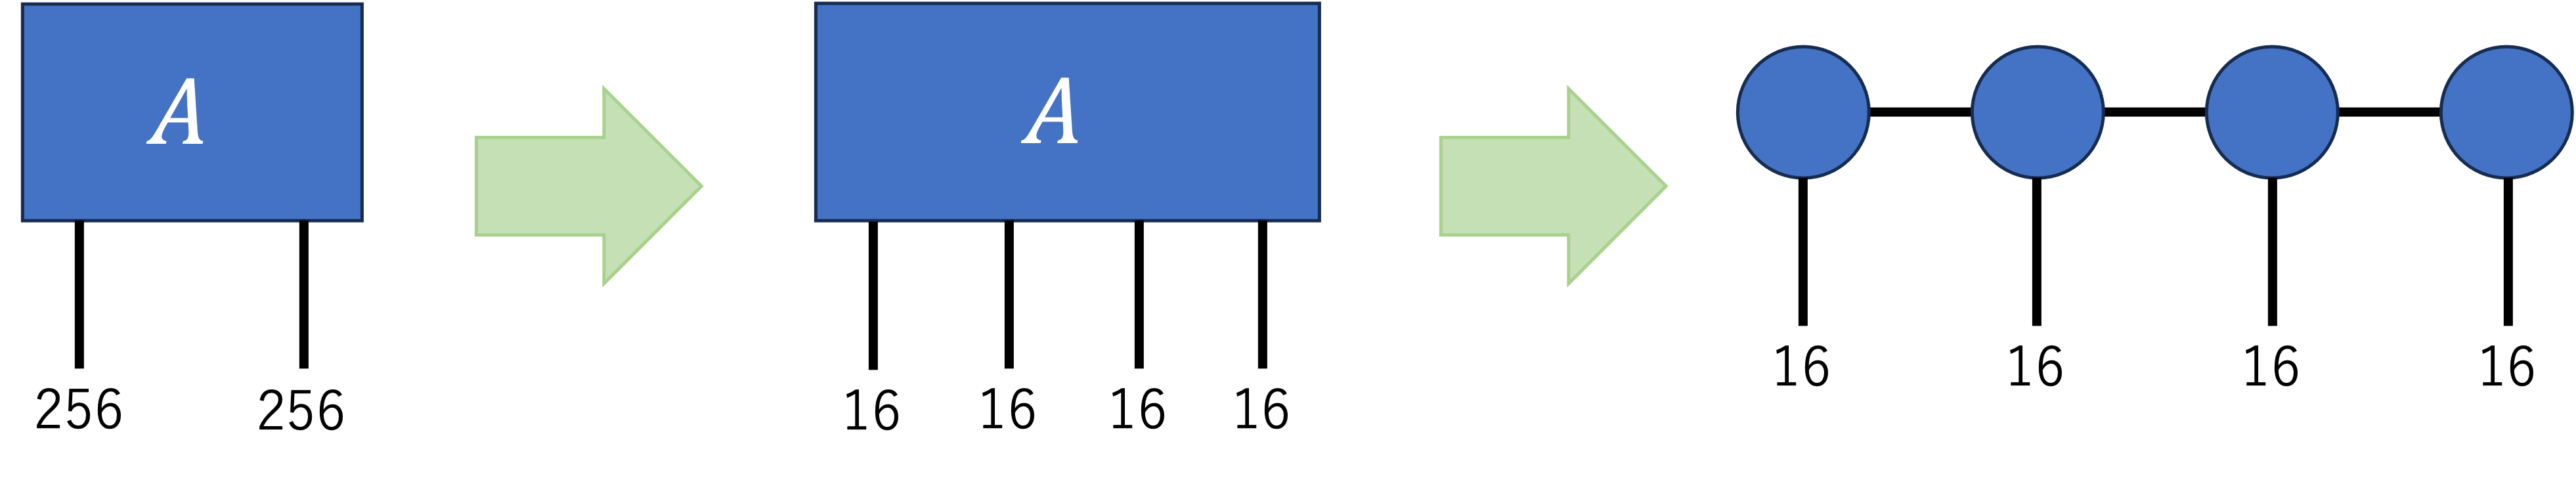

In [ ]:
W_h = model.state_dict()["2.weight"].detach().numpy()

In [ ]:
print(W_h.shape)

まず、$256 \times 256$の行列を$16 \times 16 \times 16 \times 16$の行列にします。

In [ ]:
W_h_reshaped = W_h.reshape(4,4,4,4,4,4,4,4)

W_h_tensor = W_h_reshaped.transpose(0,4,1,5,2,6,3,7).reshape(16,16,16,16)

ここで、transposeを行っているのは、最終的にNNに戻す際には入力と出力を分けて考える必要があるため、これに合わせた形にしています。

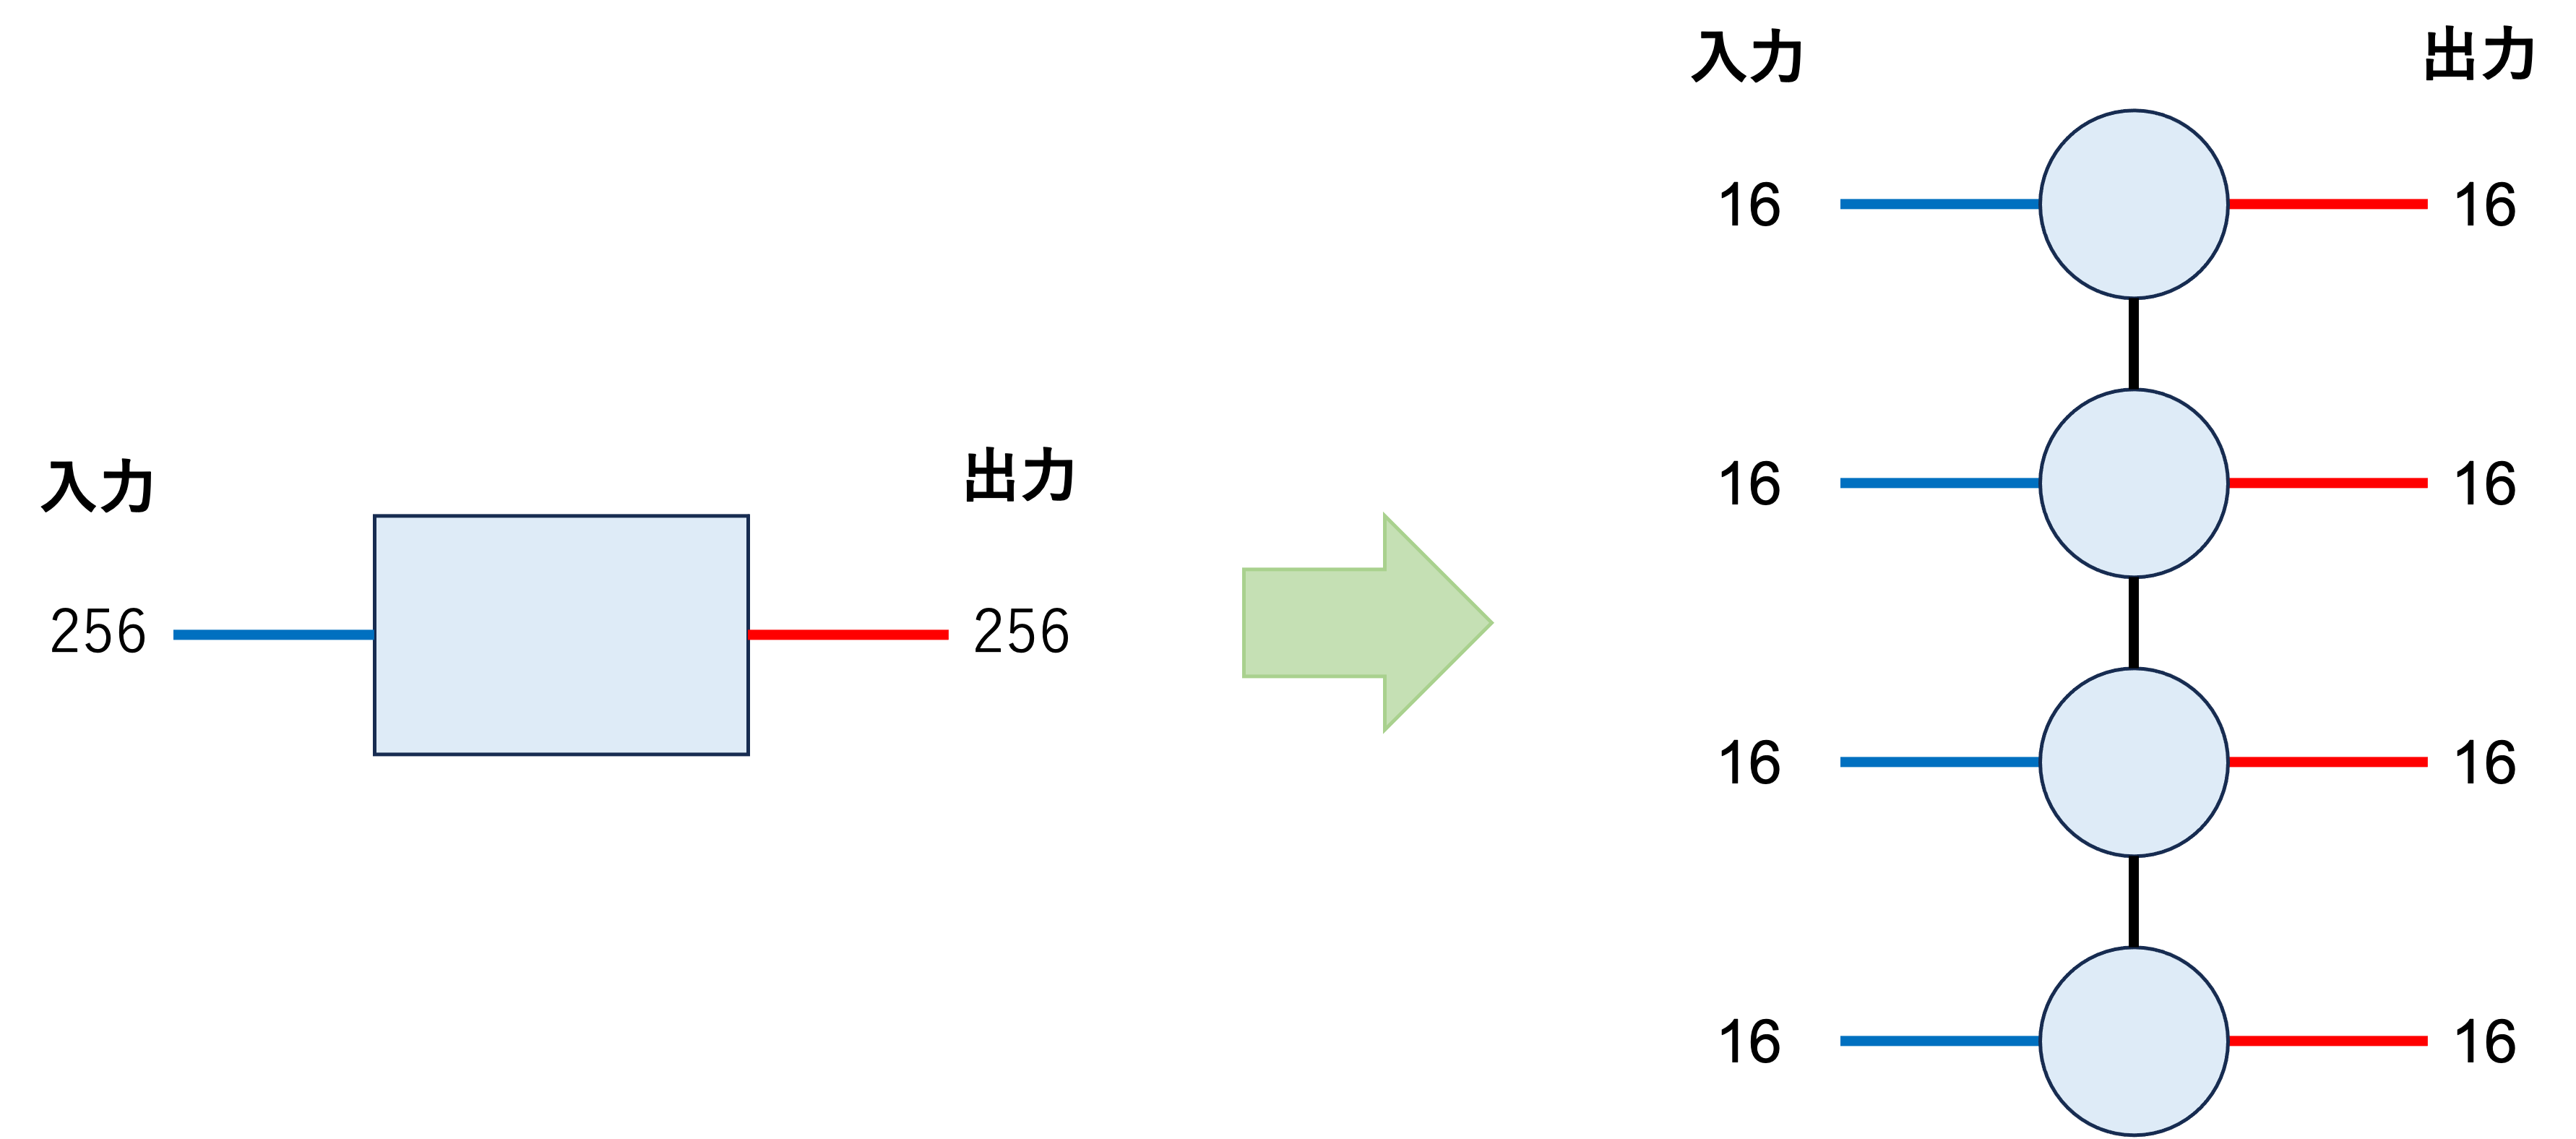

In [ ]:
from numpy.linalg import svd

u1, s1, vh1 = svd(W_h_tensor.reshape(16,16**3),full_matrices=False)

M1 = u1
u2, s2, vh2 = svd((np.diag(s1) @ vh1).reshape(16**2, 16**2),full_matrices=False)

M2 = u2.reshape(16,16,16**2)

u3, s3, vh3 = svd((np.diag(s2) @ vh2).reshape(16**3, 16),full_matrices=False)

M3 = u3.reshape(16**2,16,16)

M4 = np.diag(s3) @ vh3

分解したあとの行列から、元の行列を再構成して、誤差を確認してみます。

In [ ]:
def reconstruct_matrix(M1: np.array, M2: np.array, M3: np.array, M4: np.array) -> np.array:
    matrix = np.einsum("ij,jlm,mno,op -> ilnp",M1,M2,M3,M4,optimize=True).reshape(4,4,4,4,4,4,4,4).transpose(0,2,4,6,1,3,5,7).reshape(256,256)

    return matrix

In [ ]:
W_h_reconstructed = reconstruct_matrix(M1,M2,M3,M4)

## 誤差の確認
np.linalg.norm(W_h - W_h_reconstructed)/np.linalg.norm(W_h)

非常に小さい誤差なので、問題なく再構成できていそうです。

次に、これにボンド次元の制限を加えてみます。

In [ ]:
chi_max = 32

## M1 と M2をつなぐボンド
chi_12 = min(chi_max,M1.shape[1])
## M2 と M3をつなぐボンド
chi_23 = min(chi_max,M2.shape[2])
## M3 と M4をつなぐボンド
chi_34 = min(chi_max,M3.shape[2])

M1_ap = M1[:,:chi_12]
M2_ap = M2[:chi_12,:,:chi_23]
M3_ap = M3[:chi_23,:,:chi_34]
M4_ap = M4[:chi_34,:]

W_h_ap = reconstruct_matrix(M1_ap,M2_ap,M3_ap,M4_ap)

## 誤差の確認
np.linalg.norm(W_h - W_h_ap) / np.linalg.norm(W_h)

やや誤差としては大きい気もしますが、行列の再構成ができました。

In [ ]:
print("元の要素数")
print(W_h_tensor.size)
print("---")
print("分解後の要素数")
print(M1_ap.size, M2_ap.size, M3_ap.size, M4_ap.size)
print(M1_ap.size + M2_ap.size + M3_ap.size + M4_ap.size)

元々65,536個の要素があったものが、16,896個の要素で保持できるようになったので、データ量としては削減することに成功しています。

---
# 4. ニューラルネットワークへの導入

それでは、このように分解して作られた行列積演算子を用いて計算するようなレイヤーをニューラルネットワークへ導入します。

先ほどnumpyで実装しましたが、ここでは、torchの関数を使って実装しています。

In [ ]:
class MPO_layer(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, bond_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.bond_dim = bond_dim

        # 今回は同じサイズに4分割する前提
        assert int(input_dim ** (1/4)) ** 4 == input_dim
        assert int(output_dim ** (1/4)) ** 4 == output_dim

        tensor_input_dim = int(input_dim ** (1/4))
        tensor_output_dim = int(output_dim ** (1/4))

        # 重みを格納する行列の定義
        chi_12 = min(tensor_input_dim*tensor_output_dim, bond_dim)
        weight_1 = torch.randn(size=(tensor_output_dim, tensor_input_dim, chi_12))
        self.weight_1 = nn.Parameter(weight_1)

        chi_23 = min((tensor_input_dim*tensor_output_dim)**2, bond_dim)
        weight_2 = torch.randn(size=(chi_12, tensor_output_dim, tensor_input_dim, chi_23))
        self.weight_2 = nn.Parameter(weight_2)

        chi_34 = min((tensor_input_dim*tensor_output_dim), bond_dim)
        weight_3 = torch.randn(size=(chi_23, tensor_output_dim, tensor_input_dim, chi_34))
        self.weight_3 = nn.Parameter(weight_3)

        weight_4 = torch.randn(size=(chi_34, tensor_output_dim, tensor_input_dim))
        self.weight_4 = nn.Parameter(weight_4)

        # バイアスを格納するベクトルの定義
        bias = torch.randn(output_dim)
        self.bias = nn.Parameter(bias)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_tensor = x.reshape(-1, 4, 4, 4, 4)

        output = torch.einsum("ijl,lmno,opqr,rst,ujnqt -> uimps", self.weight_1, self.weight_2, self.weight_3, self.weight_4, x_tensor).reshape(-1, 256)
        output += self.bias
        return output

まずは、ボンド次元を制限する前のモデルを定義して、先ほどと同程度の性能が出ていることを確認します。

In [ ]:
model_2 = nn.Sequential(
    nn.Linear(62, 256),
    nn.ReLU(),
    MPO_layer(256, 256, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [ ]:
model_2[0].weight = nn.Parameter(model.state_dict()["0.weight"])
model_2[0].bias = nn.Parameter(model.state_dict()["0.bias"])

model_2[2].weight_1 = nn.Parameter(torch.from_numpy(M1.reshape(4, 4, 16)))
model_2[2].weight_2 = nn.Parameter(torch.from_numpy(M2.reshape(16, 4, 4, 256)))
model_2[2].weight_3 = nn.Parameter(torch.from_numpy(M3.reshape(256, 4, 4, 16)))
model_2[2].weight_4 = nn.Parameter(torch.from_numpy(M4.reshape(16, 4, 4)))

model_2[2].bias = nn.Parameter(model.state_dict()["2.bias"])

model_2[4].weight = nn.Parameter(model.state_dict()["4.weight"])
model_2[4].bias = nn.Parameter(model.state_dict()["4.bias"])

In [ ]:
eval_model(model_2)

性能としては全く同じ数値が出てきました。（環境によっては、わずかに差があるかもしれません。）

次に、ボンド次元を制限した場合の結果を入れてみます。

In [ ]:
model_3 = nn.Sequential(
    nn.Linear(62, 256),
    nn.ReLU(),
    MPO_layer(256, 256, 32),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [ ]:
model_3[0].weight = nn.Parameter(model.state_dict()["0.weight"])
model_3[0].bias = nn.Parameter(model.state_dict()["0.bias"])

model_3[2].weight_1 = nn.Parameter(torch.from_numpy(M1_ap.reshape(4, 4, chi_12)))
model_3[2].weight_2 = nn.Parameter(torch.from_numpy(M2_ap.reshape(chi_12, 4, 4, chi_23)))
model_3[2].weight_3 = nn.Parameter(torch.from_numpy(M3_ap.reshape(chi_23, 4, 4, chi_34)))
model_3[2].weight_4 = nn.Parameter(torch.from_numpy(M4_ap.reshape(chi_34, 4, 4)))

model_3[2].bias = nn.Parameter(model.state_dict()["2.bias"])

model_3[4].weight = nn.Parameter(model.state_dict()["4.weight"])
model_3[4].bias = nn.Parameter(model.state_dict()["4.bias"])

In [ ]:
eval_model(model_3)

若干性能が低下している様子が見えますが、先ほどよりも小さなモデルで、比較的近い性能が出せていることがわかります。

---

# 5. 追加学習

行列積演算子を組み込んだニューラルネットワークの状態でも学習を行うことができます。

ここでは、再構成後のモデルを追加学習させてみて、性能が回復できるかをみてみます。

In [ ]:
lr_3 = 1e-5
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr_3)

model_3 = train_model(model_3, optimizer_3)

元のモデルが学習済みなこともあり、やや過学習気味の挙動をしていますが、ひとまず学習はできていそうなので、これで性能を確認してみます。

In [ ]:
eval_model(model_3)

元のモデルにかなり近い性能を出せていることがわかります。

In [ ]:
print(model_3)

念のため、モデルのパラメータ数についても確認してみます。

In [ ]:
def count_params(model: torch.nn.Module):
    sum_params = 0
    for param in model.parameters():
        print(param.size(), param.nelement())
        sum_params += param.nelement()

    print("---")
    print(f"合計パラメータ数：{sum_params}")

In [ ]:
count_params(model)

In [ ]:
count_params(model_3)

大きな性能の劣化なく、元のモデルの半分以下の要素数のモデルを構築することができました。

---
# (参考) 行列積分解後のモデルで0から学習させてみる

先ほどは、学習済みのモデルから重み行列を取り出し、これを行列積状態に分解して、新たなモデルを定義し、追加学習を行いました。

追加学習ができるということは、最初からこの形のモデルを定義して、0から学習させることも可能です。

この場合、どのような性能になるのか確認してみます。

In [ ]:
model_4 = nn.Sequential(
    nn.Linear(62, 256),
    nn.ReLU(),
    MPO_layer(256, 256, 32),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [ ]:
lr_4 = 1e-4
optimizer_4 = torch.optim.Adam(model_4.parameters(), lr_4)

model_4 = train_model(model_4, optimizer_4)

In [ ]:
eval_model(model_4)

かなり高いロスの段階で学習が止まってしまいました。

性能としても、今までの結果と比べると明確に悪いです。

このため、最初から分解して学習させることは難しいように見えます。

---

# グループ演習

## テーマ1：行列演算子のボンド次元を変化させる

今回の実験では、ボンド次元の上限を32として実験を行いました。

これを変化させてみて、モデルの性能がどのようになるかを確認してみてください。

以下が元のコードです。これをうまく変化させてみて、実験してみてください。

In [ ]:
chi_max = 32

## M1 と M2をつなぐボンド
chi_12 = min(chi_max,M1.shape[1])
## M2 と M3をつなぐボンド
chi_23 = min(chi_max,M2.shape[2])
## M3 と M4をつなぐボンド
chi_34 = min(chi_max,M3.shape[2])

M1_ap = M1[:,:chi_12]
M2_ap = M2[:chi_12,:,:chi_23]
M3_ap = M3[:chi_23,:,:chi_34]
M4_ap = M4[:chi_34,:]

In [ ]:
model_5 = nn.Sequential(
    nn.Linear(62, 256),
    nn.ReLU(),
    MPO_layer(256, 256, 32), # 適切に変更してください
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

In [ ]:
model_5[0].weight = nn.Parameter(model.state_dict()["0.weight"])
model_5[0].bias = nn.Parameter(model.state_dict()["0.bias"])

model_5[2].weight_1 = nn.Parameter(torch.from_numpy(M1_ap.reshape(4, 4, chi_12)))
model_5[2].weight_2 = nn.Parameter(torch.from_numpy(M2_ap.reshape(chi_12, 4, 4, chi_23)))
model_5[2].weight_3 = nn.Parameter(torch.from_numpy(M3_ap.reshape(chi_23, 4, 4, chi_34)))
model_5[2].weight_4 = nn.Parameter(torch.from_numpy(M4_ap.reshape(chi_34, 4, 4)))

model_5[2].bias = nn.Parameter(model.state_dict()["2.bias"])

model_5[4].weight = nn.Parameter(model.state_dict()["4.weight"])
model_5[4].bias = nn.Parameter(model.state_dict()["4.bias"])

In [ ]:
eval_model(model_5)

In [ ]:
lr_5 = 1e-5
optimizer_5 = torch.optim.Adam(model_5.parameters(), lr_5)

model_5 = train_model(model_5, optimizer_5)

In [ ]:
eval_model(model_5)

## テーマ2：元のネットワーク構造を変化させてみる

分解前のニューラルネットワークの構造を色々と変化させてみて、分解を試してみましょう。

以下が元のコードです。

__注意：__ 今回のコードでは、MPO_layerに変換する際に、入力の次元がすべての足で等しくなるように4つに分解しています。

例えば、256は$4 \times 4 \times 4 \times 4$に分解しています。このような形に分解できないものはうまく動かないです。  
（任意の形への変換については、余力のある人は次の課題で試してみてください）

In [ ]:
model = nn.Sequential(
    nn.Linear(62, 256),
    nn.ReLU(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

## テーマ3：学習のハイパーパラメータを変更する

今回モデルの学習に使うオプティマイザや、学習率、バッチサイズなどを以下のように指定しています。

これらを変更することで、追加学習やゼロからの学習に与える影響を確認してみましょう。  
（得にオプティマイザと学習率が影響が大きいと思われます。）

In [ ]:
# 学習用のパラメータの指定
epochs = 200
batch_size = 128
lr = 1e-4
early_stopping_rounds = 20
optimizer = torch.optim.Adam(model.parameters(), lr)
criterion = nn.BCELoss()

## （発展課題）テーマ4：様々な分解のパターンを試してみる

今回は、与えられた行列を4つのテンソルの積に分解し、それぞれの入出力次元が等しくなるようにしました。

行列積状態への分解のやり方は一意ではないので、様々な分解のパターンを試してみましょう。

こちらの課題は実装の難易度がやや高いため、余力のある方のみ取り組んでいただければ問題ありません。

元の実装は以下のようになっています。

特定の分解のパターンを新たに実装していただいてもよいですし、より汎用的な形へ実装しなおしていただいても問題ありません。  
（後者は変更部分がかなり多くなると思うので、自信がある方以外は、まずは前者から取り組んでみるとよいと思います。）

In [ ]:
class MPO_layer(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, bond_dim: int):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.bond_dim = bond_dim

        # 今回は同じサイズに4分割する前提
        assert int(input_dim ** (1/4)) ** 4 == input_dim
        assert int(output_dim ** (1/4)) ** 4 == output_dim

        tensor_input_dim = int(input_dim ** (1/4))
        tensor_output_dim = int(output_dim ** (1/4))

        # 重みを格納する行列の定義
        chi_12 = min(tensor_input_dim*tensor_output_dim, bond_dim)
        weight_1 = torch.randn(size=(tensor_output_dim, tensor_input_dim, chi_12))
        self.weight_1 = nn.Parameter(weight_1)

        chi_23 = min((tensor_input_dim*tensor_output_dim)**2, bond_dim)
        weight_2 = torch.randn(size=(chi_12, tensor_output_dim, tensor_input_dim, chi_23))
        self.weight_2 = nn.Parameter(weight_2)

        chi_34 = min((tensor_input_dim*tensor_output_dim), bond_dim)
        weight_3 = torch.randn(size=(chi_23, tensor_output_dim, tensor_input_dim, chi_34))
        self.weight_3 = nn.Parameter(weight_3)

        weight_4 = torch.randn(size=(chi_34, tensor_output_dim, tensor_input_dim))
        self.weight_4 = nn.Parameter(weight_4)

        # バイアスを格納するベクトルの定義
        bias = torch.randn(output_dim)
        self.bias = nn.Parameter(bias)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_tensor = x.reshape(-1, 4, 4, 4, 4)

        output = torch.einsum("ijl,lmno,opqr,rst,ujnqt -> uimps", self.weight_1, self.weight_2, self.weight_3, self.weight_4, x_tensor).reshape(-1, 256)
        output += self.bias
        return output

## （発展課題）テーマ5：他のモデル圧縮手法と比較してみる

枝刈り・量子化などの他のモデル圧縮手法と比較してみましょう。

量子化については併用することも可能です。

こちらの課題は、機械学習に関する事前知識がないと困難なため、余力のある方のみ行ってください。